## ARIMA Models

ARIMA stands for Autoregressive Integrated Moving Average. Compared with the above model it uses a linear combination of past time steps, and moving averages to predict t.


## Contents 
1. ARIMA parameters analysis
2. ARIMA multi-step taining and evaluation


#### ARIMA Models Evaluated
1. Multi-setp output ARIMA






ARIMA takes only a stationary time series. As explored in the ***DATA ANALYSIS*** notebook the load data can be made stationary by ***ANALYSIS RESULTS***



We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in the model and can be estimated from Autocorrelation plots
- d: the number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: the side of the moving average window. The order of moving average.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
sns.set_style('dark')

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from model_persistence import get_persistence_dataset, train_test_split, walk_forward_evaluation, calculate_errors, plot_error

In [31]:
#load the dataset and crete the train and test sets.
data = get_persistence_dataset()
train, test = train_test_split(data)
train.head(3)

t-0 h_0  t-0 h_1  t-0 h_2  t-0 h_3  t-0 h_4  t-0 h_5  t-0 h_6  \
date                                                                        
2015-01-01  25385.0  24382.0  22734.0  21286.0  20264.0  19905.0  20010.0   
2015-01-02  27070.0  24935.0  23214.0  22540.0  22096.0  22066.0  22275.0   
2015-01-03  25564.0  23584.0  22194.0  21296.0  21145.0  21316.0  21674.0   

            t-0 h_7  t-0 h_8  t-0 h_9  ...  t-0 h_14  t-0 h_15  t-0 h_16  \
date                                   ...                                 
2015-01-01  20377.0  20094.0  20637.0  ...   24672.0   23528.0   23118.0   
2015-01-02  23025.0  23699.0  25834.0  ...   29241.0   27973.0   27320.0   
2015-01-03  22127.0  22756.0  24654.0  ...   26416.0   25362.0   24770.0   

            t-0 h_17  t-0 h_18  t-0 h_19  t-0 h_20  t-0 h_21  t-0 h_22  \
date                                                                     
2015-01-01   23606.0   26447.0   28020.0   29014.0   29571.0   29031.0   
2015-01-02   27157.0   29045.0   31967.0   33266.0   33668.0   32426.0   
2015-01-03   24501.0   24992.0   27964.0   29694.0   29874.0   28979.0   

            t-0 h_23  
date                  
2015-01-01   26798.0  
2015-01-02   29705.0  
2015-01-03   26863.0  

[3 rows x 24 columns]

### ARIMA Parameter Analysis


We will use the ARIMA model from statsmodels.api. The ARIMA takes three arguments p, d, q and represent the model's lags, differncing, and moving window size. Arriving at their inital values is done via the box-jenkins method described below:
- p: The number of lag observations in the model and can be estimated from an Autocorrelation plot as the number of lag points that show deviation outside the confidence band.
- d: The number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: The side of the moving average window. The order of moving average.

##### Startionay and differncing of the dataset

As described in the stationary test in the Data Analysis workbook, set of daily mean data was stationary. Here we test if the hourly data is stationary using the adfuller test over a period of 1 week of lags (24 * 7).

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

In [55]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

adful_t = sm.tsa.adfuller(train_flat, maxlag=24*7)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -7.804579e+00
p-value           7.339533e-12
#Lags             1.680000e+02
Observations      2.613500e+04
dtype: float64


The p-value of the test is significantly smaller than the threshold of 0.05 and therefore we ***reject the null*** and assume a stationary dataset.

Therefore the default model paramter for d (the differncing value) is 0. We will also invesitgate a differencing paramter of 24 and 168 corresponding with the previous day, and the previous week.



##### Autocorrelation and partial autocorrelation

Descrption of the plots:

ACF - Describes the direct and indirect relationships between laging (shifted) autoregressive features. I.e. the relationships between t, t-1, t-2, t-3 etc. taking into account the interrelatinships between features, in this case t-1 and t-2, t-2 and t-3 etc.

PACF - Describes only the direct relationships between lagging (shifted) and autoregressive features.

p (AR): Determining the autoregressive hyperparameter value p, is best described as the number of lags beyond which there is no significant relationship. This is seen in the ACF as the point at which plot values lie outside the significance band (light blue horizontal band)

q (MR): Determining the moving average hyperparameter value q, is described as the direct relationship with the lag feature and the feature. 

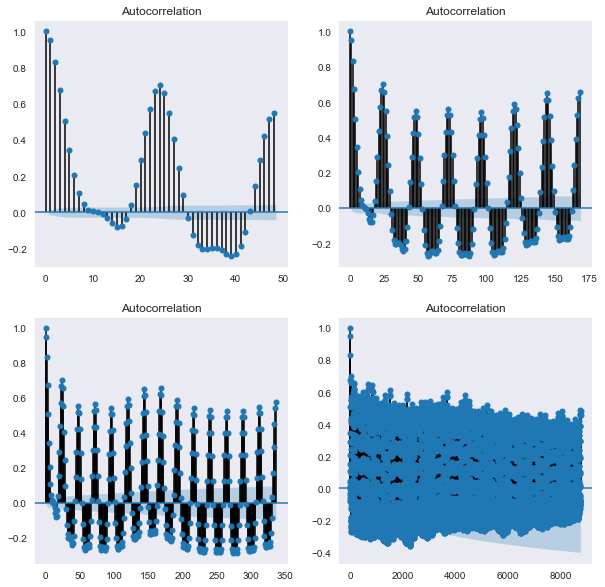

In [65]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [48, 24*7, 24*14, 24*365]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train_flat, lags=lag, ax=ax)
plt.show()

The autocorrelation plot shows significant positive corelations in the first 9 lags. However in this problem we are attempting to forecast the next 24 hours and using a lag less than 24 does not capture the full context of a short-term day ahead forecast.

The cyclic pattern of the autoregressive features is apprent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 4000 lags (approximately 1/2 year).

For the scope of this project calculating with 4000 lags is not feasible. We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).

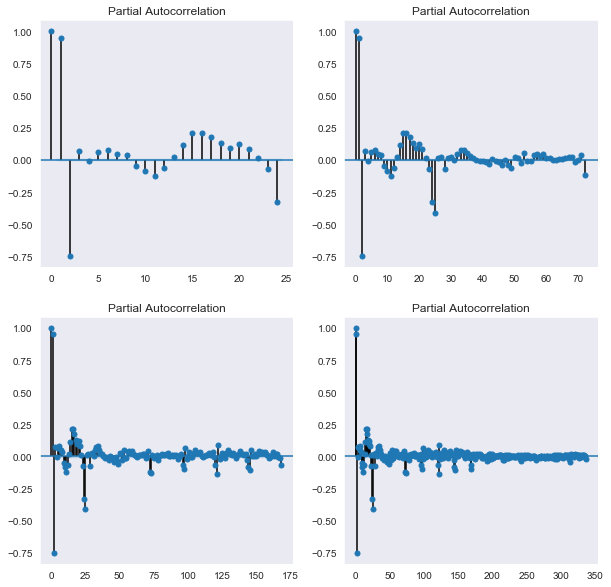

In [68]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train_flat, lags=lag, ax=ax)
plt.show()

The partial autocorrelation plot shows that beyond 24 lags there is no signficant partial autocorrelation. Considering this we will investigate lags 2, 3, 12, and 24 for the moving average values.

##### Summary of hyperparmeter values to investigate

- p (autoregressive): 24, 48, 168
- d (differncing): 0, 24, 168
- q (moving average): 0, 2, 3, 12, 24

### ARIMA Model 1: Baseline Parameters

Baseline parametres are chosen as (p, d, q) = (24, 0, 0)

In [ ]:
# able to run the arima model inside the test harness
# calcualte errors
# plot errors

# THEN we can mount google cloud VM and go BONKERS

In [10]:
### use lag of 1 as a test


def arima_model(history, config):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    p,d,q = config
    
    #initalize the ARIMA model
    model = ARIMA(history_flat, order=(p, d, q))
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast, _, _ = model_fit.forecast(24)
    
    #save the model
    #name = 'model-' + str(datetime.datetime.now()) +'.pkl'
    #model_fit.save(name)
    
    #print('Done. Model Saved.')
    
    return forecast

In [69]:
#### save aRIMA bug workaround
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

In [73]:
str(datetime.datetime.now())

'2019-09-03 12:40:59.224082'

In [79]:
errors, errors_mean = walk_forward_evaluation(arima_model, train, test, 'arima_model')

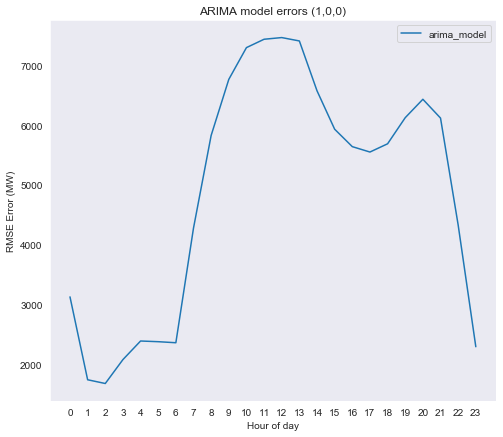

In [81]:
plot_error(errors, result_set=['arima_model'], title='ARIMA model errors (1,0,0)')

In [28]:
### reshape the data (flatten) for input into ARIMA
print(train.shape)
train.values[:2]

(1096, 24)


array([[25385., 24382., 22734., 21286., 20264., 19905., 20010., 20377.,
        20094., 20637., 22250., 23547., 24133., 24713., 24672., 23528.,
        23118., 23606., 26447., 28020., 29014., 29571., 29031., 26798.],
       [27070., 24935., 23214., 22540., 22096., 22066., 22275., 23025.,
        23699., 25834., 27927., 29072., 29071., 29439., 29241., 27973.,
        27320., 27157., 29045., 31967., 33266., 33668., 32426., 29705.]])

In [5]:
#### save aRIMA bug workaround

def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

In [6]:
ARIMA.__getnewargs__ = __getnewargs__

In [8]:
#because of the shape of the data we can flatten directly and input into the model
#
train = train.values.flatten()

In [9]:
### differencing by 24 periods
### forecast 24 periods in advance
model_24 = ARIMA(train, order=(24, 0, 0))
    
model_fit_24 = model_24.fit()
    
    
forecast_24, std_24, intervals_24 = model_fit_24.forecast(24)
print('done_')
model_fit_24.save('model_fit_24.pkl')
print('saved')

done_
saved


In [10]:
### differencing by 24 periods
### forecast 24 periods in advance
model_7 = ARIMA(train, order=(7, 0, 0))
    
model_fit_7 = model_7.fit()
    
    
forecast_7, std_7, intervals_7 = model_fit_7.forecast(24)
print('done_')
model_fit_7.save('model_fit_7.pkl')
print('saved')

done_
saved


In [58]:
### differencing by 1 periods
### forecast 1 periods in advance
model_1 = ARIMA(train_flat, order=(0, 0, 0))
    
model_fit_1 = model_1.fit()
    
    
forecast_1, std_1, intervals_1 = model_fit_1.forecast(24)
print('done_')
model_fit_1.save('model_fit_0.pkl')
print('saved')

done_
saved


In [ ]:
### differencing by 365 periods
### forecast 365 periods in advance
model_365 = ARIMA(train, order=(365, 0, 0))
    
model_fit_365 = model_365.fit()
    
    
forecast_365, std_365, intervals_365 = model_fit_365.forecast(24)
print('done_')
model_fit_365.save('model_fit_365.pkl')
print('saved')

In [16]:
loaded_1 = ARIMAResults.load('model_fit_1.pkl')
forecast_1, std_1, intervals_1=loaded_1.forecast(24)

loaded_7 = ARIMAResults.load('model_fit_7.pkl')
forecast_7, std_7, intervals_7=loaded_7.forecast(24)

loaded_24 = ARIMAResults.load('model_fit_24.pkl')
forecast_24, std_24, intervals_24=loaded_24.forecast(24)

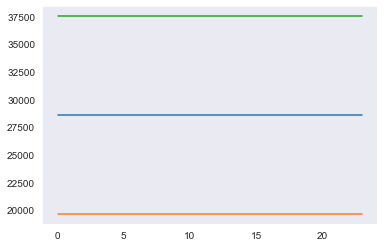

In [59]:
plt.plot(forecast_1)
plt.plot(intervals_1[:,0])
plt.plot(intervals_1[:,1])

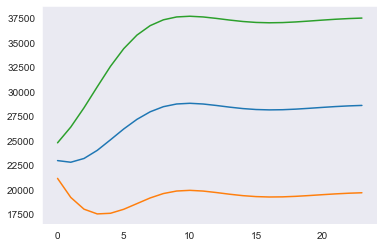

In [18]:
plt.plot(forecast_7)
plt.plot(intervals_7[:,0])
plt.plot(intervals_7[:,1])

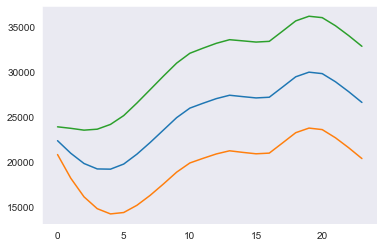

In [19]:
plt.plot(forecast_24)
plt.plot(intervals_24[:,0])
plt.plot(intervals_24[:,1])

In [1]:
from model_arima import arima_forecasts

In [3]:
config = (2, 0 , 0)
p, d, q = config
p

2

In [13]:
def arima_forecasts(model_set = {'arima_model': arima_model}, config=(1,0,0), title='Baseline Arima Model Forecast'):

    #get the data for the model
    data = get_persistence_dataset(start='2015', stop='2018')

    # set the train/test split as 0.75 to split first 3 years as train.
    train, test =train_test_split(data,split_date='2017-12-31')

    #check we are splitting in the right spot
    print('Train set start {} and stop {}' .format(train.index.min(), train.index.max()))
    print('Test set start {} and stop {}' .format(test.index.min(), test.index.max()))

    #initate error lists
    errors = []
    error_means = []

    #iterate through the models and test them in the walk forward evaluation
    for name, function in model_set.items():

        #pass the model, train and test and return the model errors and mean error
        errors_model, error_mean, predictions = walk_forward_evaluation(function, train, test, name, config)

        errors.append(errors_model)
        error_means.append(error_mean)

    errors = pd.concat([error for error in errors], axis=1)

    plot_error(errors, result_set=list(model_set.keys()), title=title)

    return errors, error_means, predictions

In [24]:
%time errors, error_mean, predictions = arima_forecasts(config=(24,0,0))

Train set start 2015-01-01 00:00:00 and stop 2017-12-31 00:00:00
Test set start 2018-01-01 00:00:00 and stop 2018-12-31 00:00:00


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ns/anaconda3/envs/tf-2-alpha/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1312, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-13-502fad553072>", line 21, in arima_forecasts
    errors_model, error_mean, predictions = walk_forward_evaluation(function, train, test, name, config)
  File "/Users/ns/code/nicholasjhana/short-term-energy-demand-forecasting/model_persistence.py", line 124, in walk_forward_evaluation
    Y_hat = model(history, config)
  File "<ipython-input-10-8731504e58cd>", line 15, in arima_model
    model_fit = model.fit()
  File "/Users/ns/anaconda3/envs/tf-2-alpha/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py", line 951, in fit
    callback=callback, **kwargs)
  File "/Users/ns/anaconda3/envs/tf-2-alpha/lib/python3.6/site-packages/statsmodels/base/model.py", line 479, in fit
    H = -1 * self.hessian(xopt)
  File "/Users/ns/anaco

KeyboardInterrupt: 

In [19]:
predictions.head()

t-0 h_0       t-0 h_1       t-0 h_2       t-0 h_3  \
date                                                                
2018-01-01  23920.27453  24148.758663  24366.030961  24572.641594   
2018-01-02  23920.27453  24148.758663  24366.030961  24572.641594   
2018-01-03  23920.27453  24148.758663  24366.030961  24572.641594   
2018-01-04  23920.27453  24148.758663  24366.030961  24572.641594   
2018-01-05  23920.27453  24148.758663  24366.030961  24572.641594   

                 t-0 h_4       t-0 h_5       t-0 h_6       t-0 h_7  \
date                                                                 
2018-01-01  24769.113735  24955.944886  25133.608134  25302.553355   
2018-01-02  24769.113735  24955.944886  25133.608134  25302.553355   
2018-01-03  24769.113735  24955.944886  25133.608134  25302.553355   
2018-01-04  24769.113735  24955.944886  25133.608134  25302.553355   
2018-01-05  24769.113735  24955.944886  25133.608134  25302.553355   

                 t-0 h_8       t-0 h_9  ...      t-0 h_14      t-0 h_15  \
date                                    ...                               
2018-01-01  25463.208345  25615.979912  ...  26274.480763  26387.442768   
2018-01-02  25463.208345  25615.979912  ...  26274.480763  26387.442768   
2018-01-03  25463.208345  25615.979912  ...  26274.480763  26387.442768   
2018-01-04  25463.208345  25615.979912  ...  26274.480763  26387.442768   
2018-01-05  25463.208345  25615.979912  ...  26274.480763  26387.442768   

                t-0 h_16      t-0 h_17      t-0 h_18      t-0 h_19  \
date                                                                 
2018-01-01  26494.861669  26597.009469  26694.144823  26786.513694   
2018-01-02  26494.861669  26597.009469  26694.144823  26786.513694   
2018-01-03  26494.861669  26597.009469  26694.144823  26786.513694   
2018-01-04  26494.861669  26597.009469  26694.144823  26786.513694   
2018-01-05  26494.861669  26597.009469  26694.144823  26786.513694   

                t-0 h_20      t-0 h_21      t-0 h_22      t-0 h_23  
date                                                                
2018-01-01  26874.349977  26957.876087  27037.303528  27112.833423  
2018-01-02  26874.349977  26957.876087  27037.303528  27112.833423  
2018-01-03  26874.349977  26957.876087  27037.303528  27112.833423  
2018-01-04  26874.349977  26957.876087  27037.303528  27112.833423  
2018-01-05  26874.349977  26957.876087  27037.303528  27112.833423  

[5 rows x 24 columns]

In [ ]:
###########################################################################################
###########################################################################################
###########################################################################################
#grid search framework with parrallel processing from jason Brownlee.

# grid search simple forecast for monthly car sales
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs


# define dataset
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,12])
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

In [26]:
###########################################################################################
###########################################################################################
###########################################################################################
#grid search framework with parrallel processing from jason Brownlee.

# grid search simple forecast for monthly car sales
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs


# define dataset
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,12])
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 3783.966
 > Model[[1, 12, 'persist']] 3783.966
 > Model[[2, 12, 'mean']] 2215.186
 > Model[[2, 1, 'persist']] 5171.658
 > Model[[3, 1, 'mean']] 4474.174
 > Model[[2, 1, 'mean']] 4119.852
 > Model[[2, 1, 'median']] 4119.852
 > Model[[2, 12, 'persist']] 5171.658
 > Model[[3, 1, 'persist']] 6000.907
 > Model[[2, 12, 'median']] 2215.186
 > Model[[3, 12, 'mean']] 2115.198
 > Model[[3, 12, 'persist']] 6000.907
 > Model[[8, 1, 'persist']] 6948.848
 > Model[[3, 1, 'median']] 4243.965
 > Model[[12, 1, 'median']] 4734.762
 > Model[[17, 1, 'persist']] 5516.237
 > Model[[21, 1, 'persist']] 6458.104
 > Model[[25, 1, 'median']] 4369.966
 > Model[[30, 1, 'persist']] 5176.877
 > Model[[34, 1, 'persist']] 5797.969
 > Model[[3, 12, 'median']] 1841.156
 > Model[[12, 12, 'persist']] 2290.827
 > Model[[8, 1, 'mean']] 4641.509
 > Model[[17, 1, 'mean']] 4040.169
 > Model[[21, 1, 'mean']] 4222.612
 > Model[[25, 12, 'persist']] 3714.571
 > Model[[30, 1, 'mean']] 4000.756
 > Model[[4

 > Model[[61, 12, 'persist']] 6014.203
 > Model[[41, 1, 'persist']] 6663.756
 > Model[[69, 1, 'mean']] 4546.075
 > Model[[45, 1, 'median']] 4678.661
 > Model[[49, 1, 'mean']] 4073.616
 > Model[[58, 1, 'persist']] 7166.502
 > Model[[53, 1, 'median']] 4666.971
 > Model[[66, 1, 'mean']] 4385.550
 > Model[[62, 1, 'persist']] 7131.119
 > Model[[41, 1, 'mean']] 3992.960
 > Model[[45, 12, 'persist']] 7545.707
 > Model[[69, 1, 'median']] 5034.885
 > Model[[53, 12, 'persist']] 6307.894
 > Model[[49, 1, 'median']] 4662.528
 > Model[[58, 1, 'mean']] 4314.621
 > Model[[62, 1, 'mean']] 4272.913
 > Model[[66, 1, 'median']] 4895.474
 > Model[[46, 1, 'persist']] 6501.924
 > Model[[69, 12, 'persist']] 8779.493
 > Model[[41, 1, 'median']] 4359.064
 > Model[[49, 12, 'persist']] 4400.110
 > Model[[54, 1, 'persist']] 6630.561
 > Model[[58, 1, 'median']] 4784.793
 > Model[[66, 12, 'persist']] 7919.315
 > Model[[41, 12, 'persist']] 6663.756
 > Model[[46, 1, 'mean']] 4198.602
 > Model[[70, 1, 'persist']] 7849

In [16]:
#### grid search framework

def grid_search(lags, diffs, mas):
    
    configs = []
    
    for lag in lags:
        for diff in diffs:
            for ma in mas:
                config = [lag, diff, ma]
                configs.append(config)
    return configs

lags = [24, 48, 168]
diffs = [0, 24, 168]
mas = [0, 2, 3, 12, 24]

len(grid_search(lags, diffs, mas))

45

In [23]:
%time grid_search(lags, diffs, mas)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 21 µs


[[24, 0, 0],
 [24, 0, 2],
 [24, 0, 3],
 [24, 0, 12],
 [24, 0, 24],
 [24, 24, 0],
 [24, 24, 2],
 [24, 24, 3],
 [24, 24, 12],
 [24, 24, 24],
 [24, 168, 0],
 [24, 168, 2],
 [24, 168, 3],
 [24, 168, 12],
 [24, 168, 24],
 [48, 0, 0],
 [48, 0, 2],
 [48, 0, 3],
 [48, 0, 12],
 [48, 0, 24],
 [48, 24, 0],
 [48, 24, 2],
 [48, 24, 3],
 [48, 24, 12],
 [48, 24, 24],
 [48, 168, 0],
 [48, 168, 2],
 [48, 168, 3],
 [48, 168, 12],
 [48, 168, 24],
 [168, 0, 0],
 [168, 0, 2],
 [168, 0, 3],
 [168, 0, 12],
 [168, 0, 24],
 [168, 24, 0],
 [168, 24, 2],
 [168, 24, 3],
 [168, 24, 12],
 [168, 24, 24],
 [168, 168, 0],
 [168, 168, 2],
 [168, 168, 3],
 [168, 168, 12],
 [168, 168, 24]]